# Yield curve fitting with PiecewiseLogCubicDiscount, PiecewiseLinearZero, PiecewiseCubicZero, Nelson-Siegel, and Nelson-Siegel-Svensson using QuantLib

In [ ]:
# Copyright © 2023 Jaakko Paavola

In [ ]:
pip install nelson-siegel-svensson


In [2]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline


In [3]:
# The range of dates to load from the data sources
start_date = "2021-07-01"
end_date = "2023-04-21"


In [4]:
########
########
### Different options for getting the yield data (the multitude of options just for my own interest and reference)
########
########


In [6]:
## Option 1) Pandas Data Reader library
# pip install pandas-datareader
import pandas_datareader.data as pdr

# Source can be one of:
# 'yahoo', 'google', 'fred', 'famafrench', 'oecd', 'eurostat', 'stooq', 'moex', 'iex', 'tiingo', 'quandl', 'alpha_vantage', 'enigma'
source = 'quandl'

data = pdr.DataReader("USTREASURY/YIELD", source, start_date, end_date, api_key="YOUR_API_KEY")


In [7]:
## Option 2) Quandl / Nasdaq Data Link API (explicitly)
# pip install quandl
import quandl
quandl.ApiConfig.api_key = "YOUR_API_KEY"

dataset_code = "USTREASURY/YIELD"

rates_fed_term_structures_quandl = quandl.get(dataset_code, start_date=start_date, end_date=end_date)

# Extract the yields and maturities from the data
maturities_years_quandl = np.array([float(i[:2])/12 if i[-2:] == 'MO' else float(i[:2]) for i in rates_fed_term_structures_quandl.columns])

maturities_months_quandl = np.array([float(i[:2])*12 if i[-2:] == 'YR' else float(i[:2]) for i in rates_fed_term_structures_quandl.columns])



In [8]:
## Option 3) FRED API (explicitly)
# pip install fredapi
from fredapi import Fred

fred = Fred(api_key='YOUR_API_KEY')

# Define the series IDs for the desired yields
series_ids = ['DGS1MO','DGS3MO','DGS6MO','DGS1','DGS2','DGS3','DGS5','DGS7','DGS10','DGS20','DGS30']

# *	DGS1MO 	1-Month Treasury Constant Maturity Rate 
# *	DGS3MO 	3-Month Treasury Constant Maturity Rate 
# *	DGS6MO 	6-Month Treasury Constant Maturity Rate 
# * DGS1  	1-Year Treasury Constant Maturity Rate
# *	DGS2 	2-Year Treasury Constant Maturity Rate 	
# *	DGS3 	3-Year Treasury Constant Maturity Rate 	
# *	DGS5 	5-Year Treasury Constant Maturity Rate 	
# *	DGS7 	7-Year Treasury Constant Maturity Rate
# *	DGS10 	10-Year Treasury Constant Maturity Rate 
# *	DGS20 	20-Year Treasury Constant Maturity Rate 
# *	DGS30 	30-Year Treasury Constant Maturity Rate 

# Get the data for all series using a loop
rates_fed_term_structures_fred = []
for series_id in series_ids:
    rates_fed_term_structures_fred.append(fred.get_series(series_id, observation_start=start_date, observation_end=end_date))

# Convert the list of series into a dataframe
rates_fed_term_structures_fred = pd.DataFrame(rates_fed_term_structures_fred).T
rates_fed_term_structures_fred.columns = series_ids

# Extract the yields and maturities from the data
maturities_years_fred = np.array([float(i[3:4])/12 if i[-2:] == 'MO' else float(i[3:]) for i in rates_fed_term_structures_fred.columns])

maturities_months_fred = np.array([float(i[3:])*12 if i[-2:] != 'MO' else float(i[3:4]) for i in rates_fed_term_structures_fred.columns])



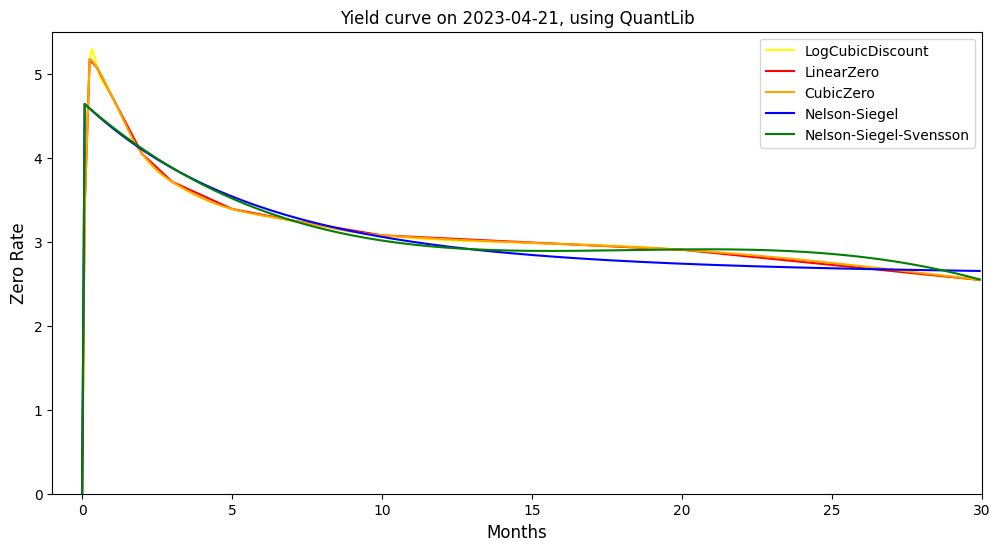

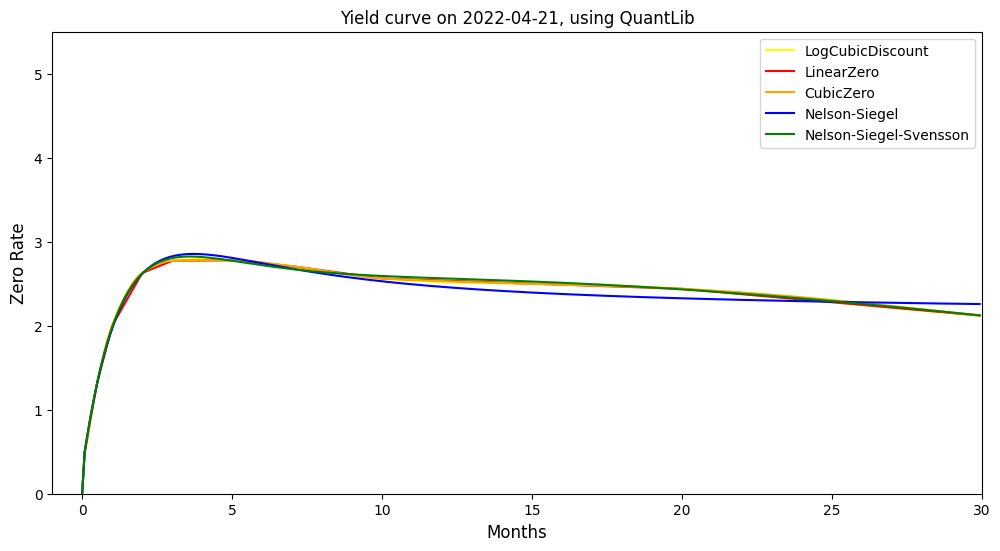

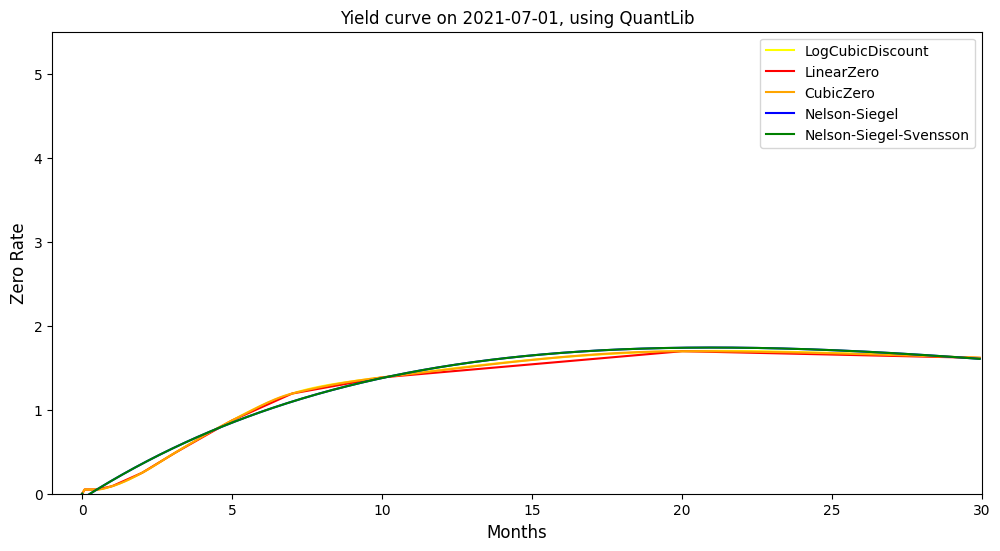

In [30]:
########
########
### Yield curve fitting into the data
########
########

# Choose the dates for the yield curve fitting
observation_dates = ["2023-04-21", "2022-04-21", "2021-07-01"]

# Choose the data source
rates_fed_term_structures = rates_fed_term_structures_fred
maturities_years = maturities_years_fred
maturities_months = maturities_months_fred

# Choose the libraries to use: either option 1 (various libraries) or option 2 (QuantLib)
library_option = 2

for observation_date in observation_dates:
    # Filter the data for the desired date
    given_term_structure_yields = rates_fed_term_structures.loc[observation_date]
    given_term_structure_yields = given_term_structure_yields.values

    if library_option == 1:
        ## Option 1) Nelson-Siegel, Nelson-Siegel-Svensson, linear interpolation, and cubic spline interpolation yield curve fitting using various libraries

        # pip install nelson_siegel_svensson
        from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
        from nelson_siegel_svensson import NelsonSiegelCurve
        from nelson_siegel_svensson.calibrate import calibrate_ns_ols
        from nelson_siegel_svensson.calibrate import calibrate_nss_ols
        from scipy.optimize import minimize
        from scipy.interpolate import CubicSpline

        # Calibrate the Nelson-Siegel model
        Nelson_Siegel, status1 = calibrate_ns_ols(maturities_years, given_term_structure_yields, tau0=1.0)

        # Calibrate the Nelson-Siegel model
        Nelson_Siegel_Svensson1, status = calibrate_nss_ols(maturities_years, given_term_structure_yields, tau0=[1.0, 1.0])

        # Perform yield curve fitting using linear interpolation
        t = np.linspace(0, 30, 30)
        interpolated_yield = np.interp(t, maturities_years, given_term_structure_yields)

        # Perform yield curve fitting using the cubic spline interpolation
        cs = CubicSpline(maturities_years, given_term_structure_yields)
        y = cs(t)

        fig, ax = plt.subplots(figsize=(12,6))
        ax.set_xlim(0,30)
        ax.set_ylim([0,5.5])
        plt.plot(t, Nelson_Siegel_Svensson1(t), color='green', label='Nelson-Siegel-Svensson')
        plt.plot(t, Nelson_Siegel(t), color='blue', label='Nelson-Siegel')
        plt.plot(interpolated_yield, label='Linear interpolation', color='red')
        plt.plot(t, y, label='Cubic spline', color='orange')
        # plt.plot(maturities_years, given_term_structure_yields, 'o', label='data')
        plt.legend(loc='best')
        ax.set_title(f"Yield curve on {observation_date}, using various Python libraries", size=12)

    else:
        ## Option 2) Quantlib: Nelson-Siegel, Nelson-Siegel-Svensson, linear interpolation, and cubic spline interpolation yield curve fitting using QuantLib (much of the code from Frank Fabozzi: Bond Markets, Analysis and Strategies, Sixth Edition.)

        # pip install QuantLib
        import QuantLib as ql

        # Toy data from the book:

        # # Deposit rates
        # depo_maturities = [ql.Period(6,ql.Months), ql.Period(12, ql.Months)]
        # depo_rates = [5.25, 5.5]

        # # Bond rates
        # bond_maturities = [ql.Period(6*i, ql.Months) for i in range(3,21)]
        # bond_rates = [5.75, 6.0, 6.25, 6.5, 6.75, 6.80, 7.00, 7.1, 7.15, 
        #               7.2, 7.3, 7.35, 7.4, 7.5, 7.6, 7.6, 7.7, 7.8]

        # Real data fetched from the data sources:
        bond_maturities = []
        for i in maturities_months:
            bond_maturities.append(ql.Period(int(i), ql.Months))
        bond_rates = given_term_structure_yields

        # maturities = depo_maturities+bond_maturities
        # rates = depo_rates+bond_rates
        maturities = bond_maturities
        rates = bond_rates

        # DataFrame(list(zip(maturities, rates)), columns=["Maturities","Curve"], index=['']*len(rates))

        # Below we declare some constants and conventions used here. For the sake of simplicity, we assume that some of the constants are the same for deposit rates and bond rates.
        calc_date = ql.Date(1, 7, 2022)
        ql.Settings.instance().evaluationDate = calc_date
        calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
        business_convention = ql.Unadjusted 
        day_count = ql.Thirty360(ql.Thirty360.BondBasis)
        end_of_month = True
        settlement_days = 0
        settlement = calendar.advance(calc_date, ql.Period(settlement_days, ql.Days))
        face_amount = 100
        # coupon_frequency = ql.Period(ql.Semiannual)
        coupon_frequency = ql.Period(ql.NoFrequency) # NO INTEREST PAYMENTS SINCE WE HAVE ZERO-COUPON BOND

        ## The basic idea of bootstrapping is to use the deposit rates and bond rates to create individual rate helpers. Then use the combination of the two helpers to construct the yield curve. As a first step, we create the deposit rate helpers as shown below.
        # depo_helpers = [
        #     ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(r/100.0)),
        #                          m,
        #                          settlement,
        #                          calendar,
        #                          business_convention,
        #                          end_of_month,
        #                          day_count)
        #     for r, m in zip(depo_rates, depo_maturities)
        # ]

        # The rest of the points are coupon bonds. We assume that the YTM given for the bonds are all par rates. So we have bonds with coupon rate same as the YTM. Using this information, we construct the fixed rate bond helpers below.
        bond_helpers = []
        for r, m in zip(bond_rates, bond_maturities):
            termination_date = calc_date + m
            schedule = ql.Schedule(calc_date,
                                termination_date, 
                                coupon_frequency, 
                                calendar,
                                business_convention, 
                                business_convention, 
                                ql.DateGeneration.Backward, 
                                end_of_month)
            
            bond_helper = ql.FixedRateBondHelper(
                ql.QuoteHandle(ql.SimpleQuote(face_amount)),
                settlement_days,
                face_amount,
                schedule,
                [r/100.0],
                day_count,
                business_convention)
            bond_helpers.append(bond_helper)

        # The union of the two helpers is what we use in bootstrapping shown below.
        # rate_helpers = depo_helpers + bond_helpers
        rate_helpers = bond_helpers

        # The `get_spot_rates` is a convenient wrapper function that we will use to get the spot rates on a monthly interval.
        def get_spot_rates(yieldcurve, day_count, calendar, months):
            spots = []
            tenors = []
            ref_date = yieldcurve.referenceDate()
            calc_date = ref_date
            for month in range(0, months):
                yrs = month/12.0
                d = calendar.advance(ref_date, ql.Period(month, ql.Months))
                compounding = ql.Compounded
                freq = ql.Semiannual
                zero_rate = yieldcurve.zeroRate(yrs, compounding, freq)
                tenors.append(yrs)
                eq_rate = zero_rate.equivalentRate(
                    day_count,compounding,freq,calc_date,d).rate()
                spots.append(100*eq_rate)
            return DataFrame(list(zip(tenors, spots)),
                            columns=["Maturities","Curve"],
                            index=['']*len(tenors))

        # The bootstrapping process is fairly generic in QuantLib. You can chose what variable you are bootstrapping, and what is the interpolation method used in the bootstrapping. There are multiple piecewise interpolation methods that can be used for this process. The `PiecewiseLogCubicDiscount` will construct a piece wise yield curve using `LogCubic` interpolation of the `Discount` factor. Similarly `PiecewiseLinearZero` will use `Linear` interpolation of `Zero` rates. `PiecewiseCubicZero` will interpolate the `Zero` rates using a `Cubic` interpolation method.
        yc_logcubicdiscount = ql.PiecewiseLogCubicDiscount(calc_date, rate_helpers, day_count)

        # The zero rates from the tail end of the `PiecewiseLogCubicDiscount` bootstrapping is shown below.
        months = maturities_months[-1]
        splcd = get_spot_rates(yc_logcubicdiscount, day_count, ql.UnitedStates(ql.UnitedStates.GovernmentBond), int(months))
        splcd.tail()

        # The yield curves using the `PiecewiseLinearZero` and `PiecewiseCubicZero` is shown below. The tail end of the zero rates obtained from `PiecewiseLinearZero` bootstrapping is also shown below. The numbers can be compared with that of the `PiecewiseLogCubicDiscount` shown above.
        yc_linearzero = ql.PiecewiseLinearZero(
            calc_date,rate_helpers,day_count
        )
        yc_cubiczero = ql.PiecewiseCubicZero(
            calc_date,rate_helpers,day_count
        )

        splz = get_spot_rates(yc_linearzero, day_count, ql.UnitedStates(ql.UnitedStates.GovernmentBond), int(months))
        spcz = get_spot_rates(yc_cubiczero, day_count, ql.UnitedStates(ql.UnitedStates.GovernmentBond), int(months))
        splz.tail()

        yc_nelson_siegel = ql.FittedBondDiscountCurve(0, calendar, rate_helpers, ql.SimpleDayCounter(),ql.NelsonSiegelFitting())

        spns = get_spot_rates(yc_nelson_siegel, day_count, ql.UnitedStates(ql.UnitedStates.GovernmentBond), int(months))

        yc_nelson_siegel_svensson = ql.FittedBondDiscountCurve(0, calendar, rate_helpers, ql.SimpleDayCounter(),ql.SvenssonFitting())

        spnss = get_spot_rates(yc_nelson_siegel_svensson, day_count, ql.UnitedStates(ql.UnitedStates.GovernmentBond), int(months))

        fig, ax = plt.subplots(figsize=(12,6))
        ax.plot(splcd["Maturities"],splcd["Curve"], label="LogCubicDiscount", color="yellow")
        ax.plot(splz["Maturities"],splz["Curve"], label="LinearZero", color="red")
        ax.plot(spcz["Maturities"],spcz["Curve"], label="CubicZero", color="orange")
        ax.plot(spns["Maturities"],spns["Curve"], label="Nelson-Siegel", color="blue")
        ax.plot(spnss["Maturities"],spnss["Curve"], label="Nelson-Siegel-Svensson", color="green")
        ax.set_xlabel("Months", size=12)
        ax.set_ylabel("Zero Rate", size=12)
        ax.set_xlim(-1,30)
        ax.set_ylim([0, 5.5])
        ax.legend(loc=0)
        ax.set_title(f"Yield curve on {observation_date}, using QuantLib", size=12)
